In [1]:

####Rene 7_30_2021 update 4/1/2022
# Import the os module
import os
import pandas as pd
import numpy as np

#Generate clusters of ms features across depth.
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

#This file is for development. Main functions are embedded here.

# Change the current working directory
os.chdir('/Users/boiteaur/Desktop/CoreMS_metallomics/CoreMS')

###### Set file folder and THERMO RAW file name here:
file_location='/Users/boiteaur/Desktop/Major projects/Bermuda Atlantic Time Series data processing/Thermo RAW data'
files=os.listdir('/Users/boiteaur/Desktop/Major projects/Bermuda Atlantic Time Series data processing/Thermo RAW data')

import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("./")
from pathlib import Path
import matplotlib.pyplot as plt


from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import matplotlib.backends.backend_pdf

refmasslist = Path.cwd() / "tests/tests_data/ftms/nom_pos.ref"

#Set peak detection threshold method
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.25
MSParameters.molecular_search.max_ppm_error = 0.25

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,4)
#MSParameters.molecular_search.usedAtoms['S'] = (0,0)

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"
#Read in sample list and load MS data

samplelist=pd.read_csv(file_location+'/'+'BATS_samplelist.csv')

MSfiles={}
for file in samplelist['File'][samplelist['type']=='sample']:
#for file in samplelist.File:
    parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file_location+'/'+file)
    MSfiles[file]=parser

print(samplelist)

samplelist=samplelist[samplelist['File'].isin(MSfiles.keys())]

                            File          type  run order  Sample number  \
0     RMB_190828_BATS01_100m.raw  other_sample          4            1.0   
1       RMB_190828_BATS02_5m.raw  other_sample          5            2.0   
2       RMB_190828_BATS03_5m.raw  other_sample          6            3.0   
3     RMB_190828_BATS04_250m.raw  other_sample          7            4.0   
4     RMB_190828_BATS05_300m.raw        sample          8            5.0   
5     RMB_190828_BATS06_400m.raw        sample          9            6.0   
6     RMB_190828_BATS07_500m.raw        sample         10            7.0   
7     RMB_190828_BATS08_100m.raw        sample         11            8.0   
8     RMB_190828_BATS09_200m.raw        sample         13            9.0   
9     RMB_190828_BATS10_800m.raw        sample         14           10.0   
10   RMB_190828_BATS11_1000m.raw        sample         15           11.0   
11      RMB_190828_BATS12_5m.raw        sample         16           12.0   
12     RMB_1

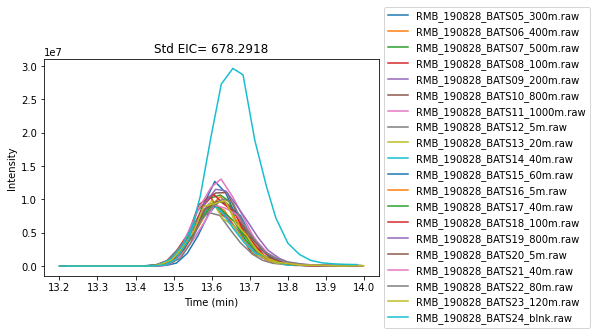

19
pass of
20
12.3 % std dev


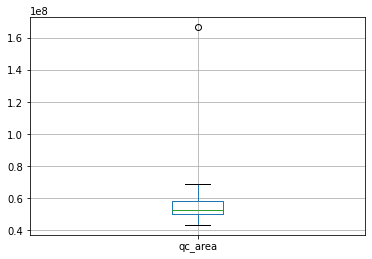

In [3]:
#QC control 

stdmass=678.2918
std_timerange=[13.2,14]

#QC control 

#stdmass=389.1960
#std_timerange=[5,30]

area=[]
rt=[]
fig=plt.figure()
ax=plt.subplot(111)
ax.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass))

for file in MSfiles.keys():
    EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
    df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
    df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
    area.append(sum(df_sub['EIC']))
    rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
    ax.plot(df_sub['time'],df_sub['EIC'],label=file)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

samplelist['qc_area']=area
samplelist['qc_rt']=rt

#plt.savefig('Fig1_qcplot.eps', format='eps')

plt.show()

peak_stdv=samplelist[samplelist.type=='sample'].qc_area.std()
peak_mean=samplelist[samplelist.type=='sample'].qc_area.mean()

samplelist[samplelist.type=='sample'].boxplot(column=['qc_area'])

samplelist['qc_pass']=0
for i in samplelist.index:
    if (abs(samplelist.qc_area[i]-peak_mean)<2*peak_stdv):
        samplelist.qc_pass[i]=1

print(samplelist[samplelist.type=='sample'].qc_pass.sum())
print('pass of')
print(len(samplelist[samplelist.type=='sample']))

peak_stdv=samplelist[samplelist.qc_pass==1].qc_area.std()
peak_mean=samplelist[samplelist.qc_pass==1].qc_area.mean()

print(str(round(peak_stdv/peak_mean*100,1))+' % std dev')

In [4]:
#Function to build formula assignment lists
#Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 
interval=2
timerange=[4,30]

B=21 #magnetic field strength
T=0.6 #transient time

def lcmsformula(parser,interval,timerange):
    tic=parser.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})

    times=list(range(timerange[0],timerange[1],interval))

    results=[]
    
    for timestart in times:

        scans=tic_df[tic_df.time.between(timestart,timestart+interval)].scan.tolist()

        #Now, get an average mass spectrum and list the centroided m/z values of the spectrum. One of these should be the molecule of interest.
        mass_spectrum = parser.get_average_mass_spectrum_by_scanlist(scans)
        mass_spectrum.filter_by_min_resolving_power(B, T)
    
        mass_spectrum.settings.min_calib_ppm_error = 2
        mass_spectrum.settings.max_calib_ppm_error = -2
        #mass_spectrum.mass_spectrum.settings.calib_sn_threshold
        #mass_spectrum.mass_spectrum.settings.calib_pol_order
        #mass_spectrum.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)
        #MzDomainCalibration(mass_spectrum, ref_file_location).run()
        calfn = MzDomainCalibration(mass_spectrum, refmasslist)
        ref_mass_list_fmt = calfn.load_ref_mass_list(refmasslist)

        imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt,
                                                    calib_ppm_error_threshold=(0, 2.0),
                                                    calib_snr_threshold=3)

        calfn.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)


        SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

        mass_spectrum.percentile_assigned(report_error=True)

        assignments=mass_spectrum.to_dataframe()

        assignments['Time']=timestart

        results.append(assignments)
        #results(timestart)=assignments[assignments['Calculated m/z']>1].filter(['m/z','corr','Peak Height','Confidence Score','Molecular Formula','Time']))
    
    results=pd.concat(results,ignore_index=True)

    return(results)

In [5]:
#### Core feature extraction function.
masterresults={}

for file in MSfiles:
    print(file)
    results=lcmsformula(MSfiles[file],interval,timerange)
    results['File']=file
    masterresults[file]=results

#This will create masterresults_df from above masterresults and save
masterresults_df=pd.concat(masterresults.values())
masterresults_df.to_csv(file_location+'masterresults_4.csv')

RMB_190828_BATS05_300m.raw


KeyboardInterrupt: 

In [10]:
#masterresults_df=pd.concat(masterresults.values())
#masterresults_df.to_csv(file_location+'masterresults_2.csv')

64010
113010
201010
322010


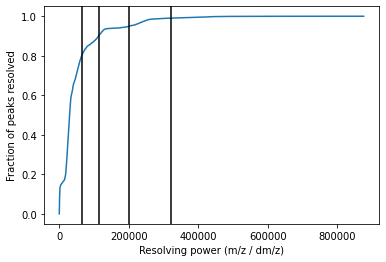

In [3]:
#Make plots showing required resolving power.

#This will load a previous masterresults_df
masterresults_df=pd.read_csv(file_location+'masterresults_4.csv')

#Note, this line filters masterresults to only contain samples.
masterresults_df=masterresults_df[masterresults_df.File.isin(samplelist.File[samplelist.type=='sample'])]

diff_summary=[]
res_summary=[]
for time in masterresults_df['Time'].unique():
    result=masterresults_df[masterresults_df['Time']==time]

    for file in masterresults_df['File'].unique():
        result_sub=result[result['File']==file]
        result_sub=result_sub['m/z'].sort_values(ascending=True)
        #mzdiff=result_sub['m/z'].sort_values(ascending=True).diff().iloc[1:]
        #mzdiff_res=result_sub['m/z'].iloc[1:]/mzdiff
        differences=result_sub.diff()


        #Resolve from peaks on either side:
        mzdiff=pd.DataFrame({'left':differences[1:-1].to_list(),'right':differences[2:].to_list(),'mz':result_sub[1:-1].to_list()})
        mzdiff_min=abs(mzdiff.min(axis=1))
        mzdiff_res=mzdiff['mz']/(mzdiff_min/2)

        diff_summary.extend(mzdiff_min.tolist())
        res_summary.extend(mzdiff_res[mzdiff_res<1e6].tolist())
        #res_summary.extend(mzdiff_res.tolist())

#print(diff_summary)

res=list(range(10,int(max(res_summary)),1000))

count=[]
for i in res:
    count.append(len([element for element in res_summary if element<i])/len(res_summary))

#print(len(diff_summary))
#print(len([element for element in diff_summary if element<0.01]))

plt.plot(res,count)
for i in [0.8,0.9,0.95,0.99]:
    current=abs(np.array(count)-i).tolist()
    print(res[current.index(min(current))])
    plt.axvline(res[current.index(min(current))],color='black')
plt.xlabel('Resolving power (m/z / dm/z)')
plt.ylabel('Fraction of peaks resolved')

#plt.hist(diff_summary, bins=50,range=[0,.03])
#plt.xlabel('m/z diff (Da)')
#plt.ylabel('frequency')

plt.xlabel('Resolving power (m/z / dm/z)')
plt.ylabel('Fraction of peaks resolved')

plt.show()


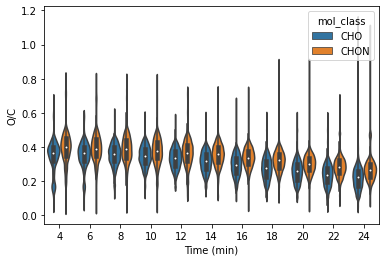

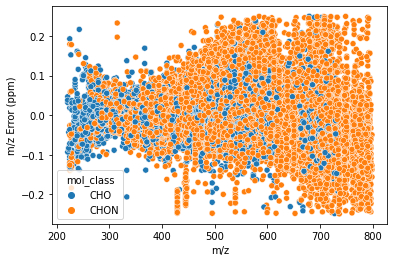

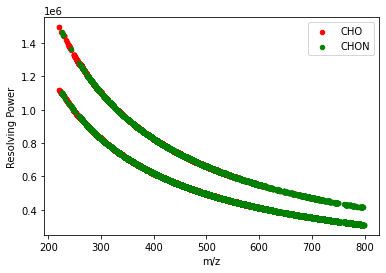

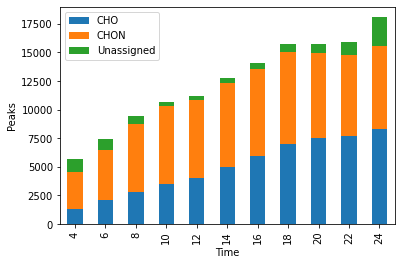

In [8]:
# Plot clean results. 

allresults=masterresults_df[(masterresults_df['m/z']<800) & (masterresults_df['S/N']>3)]

allresults['N']=allresults['N'].fillna(0)
allresults['O']=allresults['O'].fillna(0)
#allresults['S']=allresults['S'].fillna(0)
#allresults['P']=allresults['P'].fillna(0)
#allresults['Na']=allresults['Na'].fillna(0)

allresults['mol_class']='Unassigned'
allresults['mol_class'][allresults['C']>0]='CHO'
allresults['mol_class'][(allresults['C']>0) & (allresults['N']>0.5)]='CHON'
#allresults['mol_class'][(allresults['C']>0) & (allresults['S']>0.5)]='CHOS'
#allresults['mol_class'][(allresults['C']>0) & (allresults['P']>0.5)]='CHOP'
#allresults['mol_class'][(allresults['C']>0) & (allresults['Na']>0.5)]='CHONa'
#allresults['mol_class'][(allresults['C']>0) & (allresults['S']>0.5) & (allresults['N']>0.5)]='CHONS'
#allresults['mol_class'][(allresults['C']>0) & (allresults['P']>0.5) & (allresults['N']>0.5)]='CHONP'
#allresults['mol_class'][(allresults['C']>0) & (allresults['Na']>0.5) & (allresults['N']>0.5)]='CHONNa'
#allresults['mol_class'][(allresults['C']>0) & (allresults['P']>0.5) & (allresults['Na']>0.5) & (allresults['N']>0.5)]='CHONPNa'


results= allresults[allresults['Is Isotopologue']==0]
results['O/C']=results['O']/results['C']
results['H/C']=results['H']/results['C']
results['N/C']=results['N']/results['C']


colors = {'CHO':'red', 'CHON':'green', 'CHOS':'blue', 'CHONS':'yellow', 'CHONP':'black', 'CHONNa':'cyan','CHONPNa':'pink','CHONa':'aqua','CHOP':'gray'}

grouped=results.groupby('mol_class')

fig, (ax) = plt.subplots(1)
sns.violinplot(x="Time", y="O/C", hue='mol_class', data=results, ax=ax)

ax.set(xlabel='Time (min)')

fig, (ax) = plt.subplots(1)
sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='mol_class',data=results,ax=ax)
#for key, group in grouped:
#    group.plot(ax=ax,kind='scatter',x='m/z',y='m/z Error (ppm)',color=colors[key],label=key)


fig, (ax) = plt.subplots(1)
for key, group in grouped:
    group.plot(ax=ax,kind='scatter',x='m/z',y='Resolving Power',color=colors[key],label=key)
    
assign_summary=[]
for time in allresults['Time'].unique():
    current={}
    current['Time']=time
    for mol_class in sorted(allresults['mol_class'].unique()):
        current[mol_class]=len(allresults[(allresults['mol_class']==mol_class) & (allresults['Time']==time)])
    assign_summary.append(current)
df=pd.DataFrame(assign_summary)

df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks')

plt.show()


In [11]:
df.to_csv(file_location+'grouped_results_for_error_analysis.csv')

136630
11950


<AxesSubplot:xlabel='m/z', ylabel='Resolving Power'>

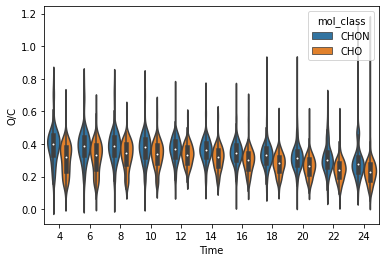

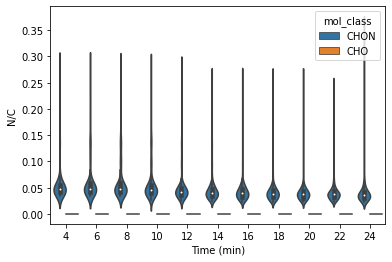

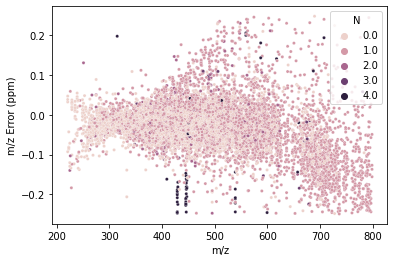

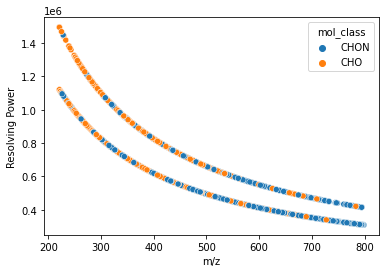

In [17]:
#Create a list of all unique features and describe their intensity. 
print(len(allresults))
#define a list of unique features (time, formula) with 'areas' determined for each sample. There may be a slight bug that causes the unique list to grow...
uniquelist=[]
for time in allresults.Time.unique():
    current=allresults[allresults.Time==time]
    current=current.sort_values(by=['m/z Error (ppm)'],ascending=True)
    currentunique=current.drop_duplicates(subset=['Molecular Formula'])
    currentunique=currentunique[currentunique['C']>1]
    currentunique=currentunique.set_index(['Molecular Formula'],drop=False)
    for file in allresults['File'].unique():
        current_file=current[current['File']==file].drop_duplicates(subset=['Molecular Formula'])
        current_file=current_file.rename(columns={'Peak Height':file})
        current_file=current_file.set_index(['Molecular Formula'],drop=False)
        currentunique=currentunique.join(current_file[file])
    uniquelist.append(currentunique)

uniqueresults=pd.concat(uniquelist,ignore_index=True)
uniqueresults['N/C']=uniqueresults['N']/uniqueresults['C']
uniqueresults['blank']=uniqueresults['RMB_190828_BATS24_blnk.raw']/uniqueresults['Peak Height']
#uniqueresults=uniqueresults[uniqueresults['blank']<0.9]


print(len(uniqueresults))


fig, (ax) = plt.subplots(1)
sns.violinplot(x="Time", y="O/C", hue='mol_class', data=uniqueresults, ax=ax)

fig, (ax) = plt.subplots(1)
sns.violinplot(x="Time", y="N/C", hue='mol_class', data=uniqueresults, ax=ax)

ax.set(xlabel='Time (min)')

fig, (ax) = plt.subplots(1)
sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='N',data=uniqueresults,ax=ax,s=10)


fig, (ax) = plt.subplots(1)
sns.scatterplot(x='m/z',y='Resolving Power',hue='mol_class',data=uniqueresults,ax=ax)


In [12]:
uniqueresults.to_csv(file_location+'grouped_results_for_error_analysis.csv')

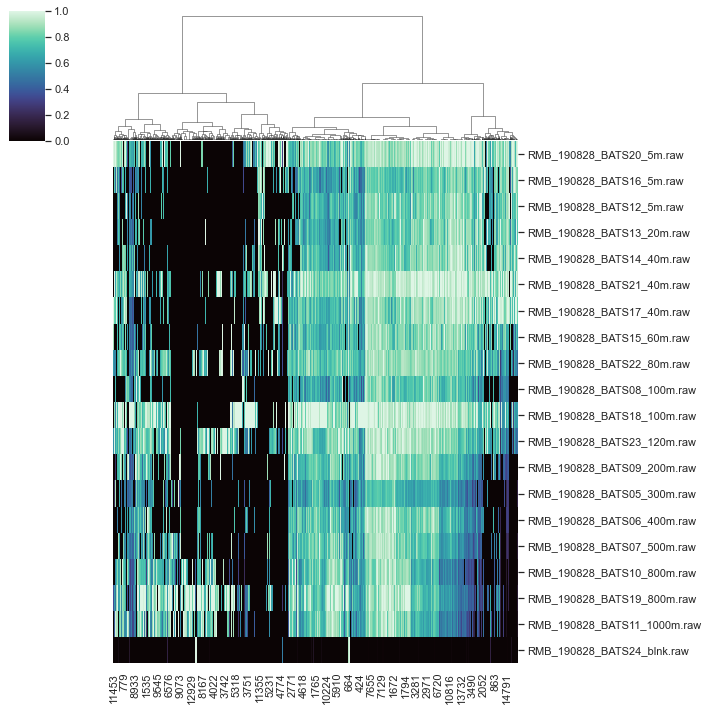

In [92]:
#Generate clusters of ms features across depth.
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize


#Blank filtering:


#clustermethod='average'
clustermethod='ward'

abundances=uniqueresults[masterresults_df['File'].unique()].fillna(0)

df=abundances.mean(axis=1)
df_std=abundances.std(axis=1)

p_list=[]
for ind in abundances.index:
    p=max(abs(abundances.loc[ind]-df[ind]))/df_std[ind]
    if len(abundances.loc[ind][abundances.loc[ind]>1])<2:
        p=0
    p_list.append(p)

#abundances['p']=p_list
#abundances=abundances[abundances['p']>0.1]
#abundances=abundances.sort_values(by='p',ascending=False)

uniqueresults['p']=p_list

#plt.hist(p_list,bins=100,range=[min(p_list),max(p_list)])

results_clustered=uniqueresults[uniqueresults['p']>0.1]
norm_abundances=results_clustered[masterresults_df['File'].unique()].fillna(0)
norm_abundances=norm_abundances.div(norm_abundances.max(axis=1),axis=0)


cluster = AgglomerativeClustering(n_clusters=3,affinity='euclidean',linkage=clustermethod)
cluster.fit_predict(norm_abundances)

results_clustered['cluster']=cluster.labels_

#results_clustered.fillna(0).to_csv(file_location+'clustered_results.csv')

depth=[]
for file in masterresults_df['File'].unique():
    d=samplelist[samplelist['File']==file]['Depth'].iloc[0]
    depth.append(d)

clusterplot=norm_abundances
#clusterplot=clusterplot.drop(['p'],axis=1)
clusterplot=clusterplot.transpose()
clusterplot['Depth']=depth
clusterplot=clusterplot.sort_values(by='Depth')
clusterplot=clusterplot.drop(['Depth'],axis=1)
p1=sns.clustermap(clusterplot,row_cluster=False,cmap='mako',method=clustermethod)

plt.show()



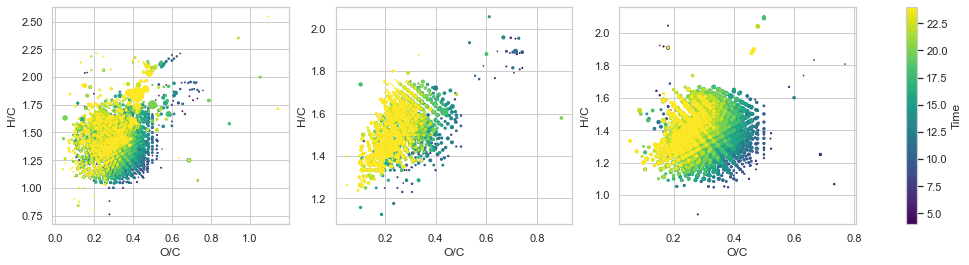

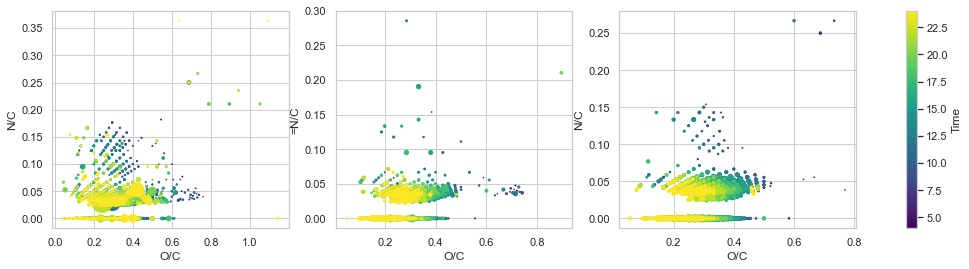

In [93]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(18,4)
preresults=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==0)]
p1=ax1.scatter(x=preresults['O/C'],y=preresults['H/C'],s=preresults['Peak Height']/4000,c=preresults['Time'],cmap='viridis')
ax1.set(xlabel='O/C',ylabel='H/C')
#ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)
preresults=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==1)]
ax2.scatter(x=preresults['O/C'],y=preresults['H/C'],s=preresults['Peak Height']/4000,c=preresults['Time'],cmap='viridis')
ax2.set(xlabel='O/C',ylabel='H/C')
preresults=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==2)]
ax3.scatter(x=preresults['O/C'],y=preresults['H/C'],s=preresults['Peak Height']/4000,c=preresults['Time'],cmap='viridis')
ax3.set(xlabel='O/C',ylabel='H/C')

fig.colorbar(p1,ax=[ax1,ax2,ax3],label='Time')

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(18,4)
preresults=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==0)]
p1=ax1.scatter(x=preresults['O/C'],y=preresults['N/C'],s=preresults['Peak Height']/4000,c=preresults['Time'],cmap='viridis')
ax1.set(xlabel='O/C',ylabel='N/C')
#ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)
preresults=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==1)]
ax2.scatter(x=preresults['O/C'],y=preresults['N/C'],s=preresults['Peak Height']/4000,c=preresults['Time'],cmap='viridis')
ax2.set(xlabel='O/C',ylabel='=N/C')
preresults=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==2)]
ax3.scatter(x=preresults['O/C'],y=preresults['N/C'],s=preresults['Peak Height']/4000,c=preresults['Time'],cmap='viridis')
ax3.set(xlabel='O/C',ylabel='N/C')

fig.colorbar(p1,ax=[ax1,ax2,ax3],label='Time')

plt.show()



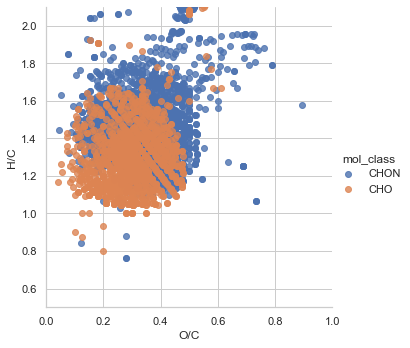

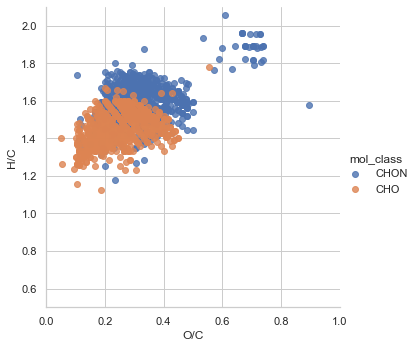

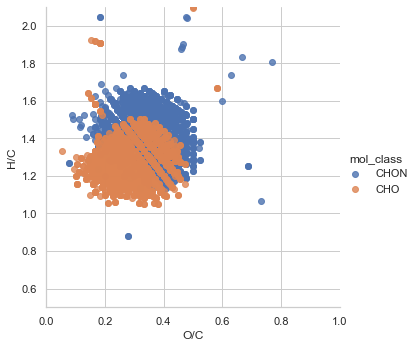

In [94]:
p1=sns.lmplot('O/C', 'H/C', data=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==0)], hue='mol_class', fit_reg=False)
p2=sns.lmplot('O/C', 'H/C', data=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==1)], hue='mol_class', fit_reg=False)
p3=sns.lmplot('O/C', 'H/C', data=results_clustered[(results_clustered['Is Isotopologue']==0) & (results_clustered['cluster']==2)], hue='mol_class', fit_reg=False)
p1.set(xlim=[0,1],ylim=[0.5,2.1])
p2.set(xlim=[0,1],ylim=[0.5,2.1])
p3.set(xlim=[0,1],ylim=[0.5,2.1])

plt.show()

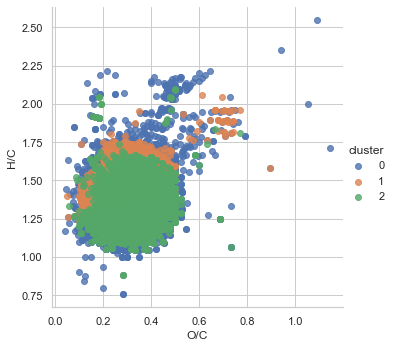

In [95]:
p1=sns.lmplot('O/C', 'H/C', data=results_clustered, hue='cluster',fit_reg=False)

plt.show()

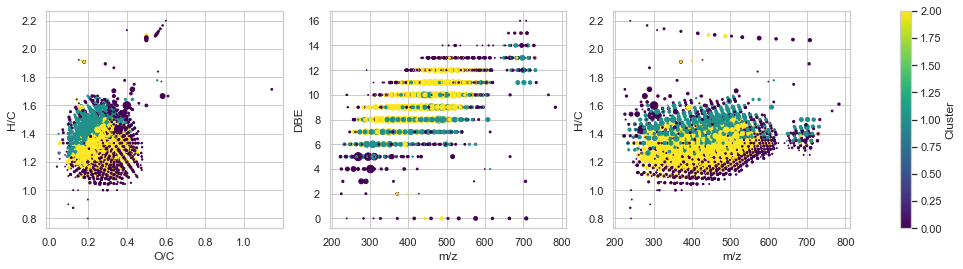

In [96]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(18,4)
preresults=results_clustered[(results_clustered['Is Isotopologue']==0)]
#preresults=results_clustered[(results_clustered['cluster']>0)]
preresults=preresults[preresults['N']<0.5]

p1=ax1.scatter(x=preresults['O/C'],y=preresults['H/C'],s=preresults['Peak Height']/4000,c=preresults['cluster'],cmap='viridis')
ax1.set(xlabel='O/C',ylabel='H/C')
#ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)
ax2.scatter(x=preresults['m/z'],y=preresults['DBE'],s=preresults['Peak Height']/4000,c=preresults['cluster'],cmap='viridis')
ax2.set(xlabel='m/z',ylabel='DBE')
ax3.scatter(x=preresults['m/z'],y=preresults['H/C'],s=preresults['Peak Height']/4000,c=preresults['cluster'],cmap='viridis')
ax3.set(xlabel='m/z',ylabel='H/C')

fig.colorbar(p1,ax=[ax1,ax2,ax3],label='Cluster')



In [ ]:
#Class graphs. (Total abundances of features)


4531


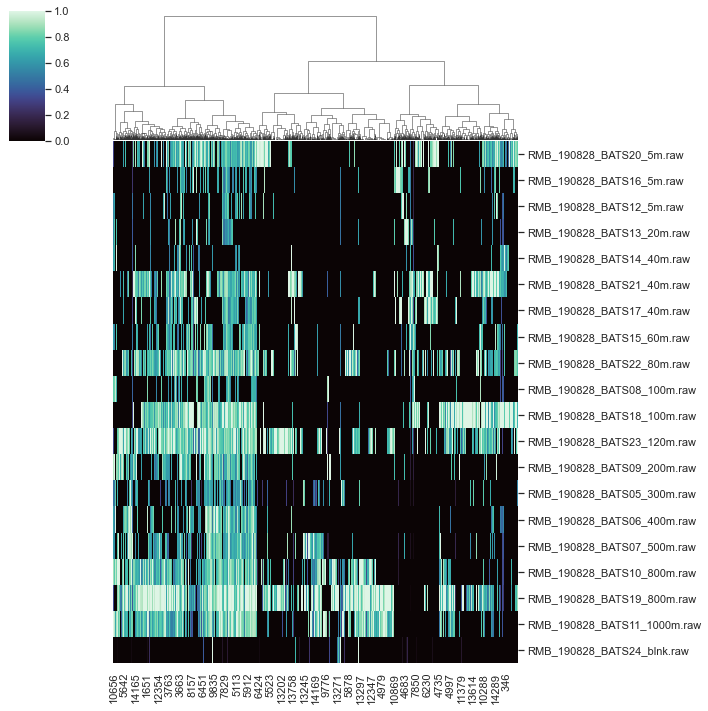

In [89]:
#Define Deep OM
abundances=results_clustered
abundances=abundances.sort_values(by='p',ascending=False)
abundances=abundances[abundances['cluster']==0]
abundances=abundances[masterresults_df['File'].unique()].fillna(0)
clusterplot=abundances.transpose()
print(len(abundances))
for column in clusterplot:
    current=clusterplot[column]
    clusterplot[column]=(current-min(current))/(max(current)-min(current))

clusterplot['Depth']=depth
clusterplot=clusterplot.sort_values(by='Depth')
clusterplot=clusterplot.drop(['Depth'],axis=1)
p1=sns.clustermap(clusterplot,row_cluster=False,cmap='mako',method=clustermethod)

plt.show()

5051


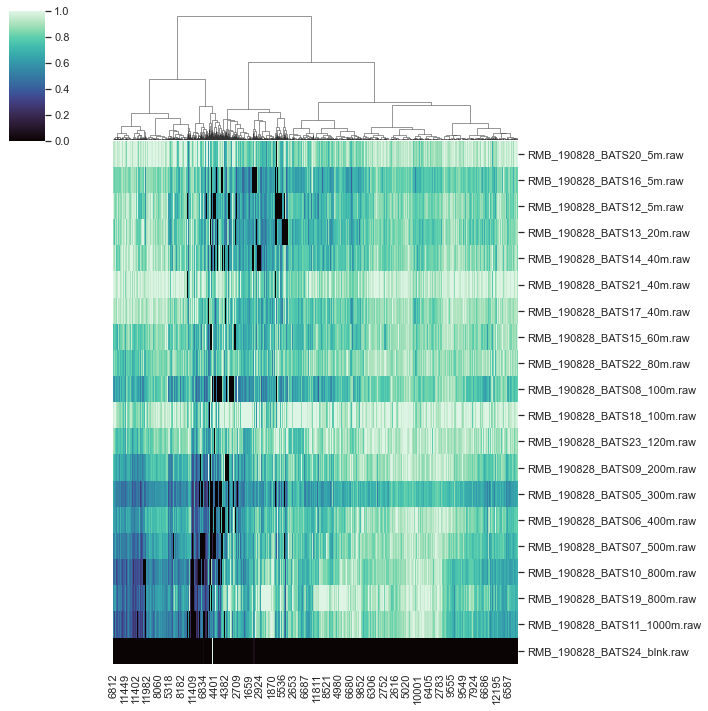

In [49]:
#Define RDOM
abundances=results_clustered
abundances=abundances.sort_values(by='p',ascending=False)
abundances=abundances[abundances['cluster']==1]
abundances=abundances[masterresults_df['File'].unique()].fillna(0)
clusterplot=abundances.transpose()
print(len(abundances))
for column in clusterplot:
    current=clusterplot[column]
    clusterplot[column]=(current-min(current))/(max(current)-min(current))

clusterplot['Depth']=depth
clusterplot=clusterplot.sort_values(by='Depth')
clusterplot=clusterplot.drop(['Depth'],axis=1)
p1=sns.clustermap(clusterplot,row_cluster=False,cmap='mako',method=clustermethod)

plt.show()

825


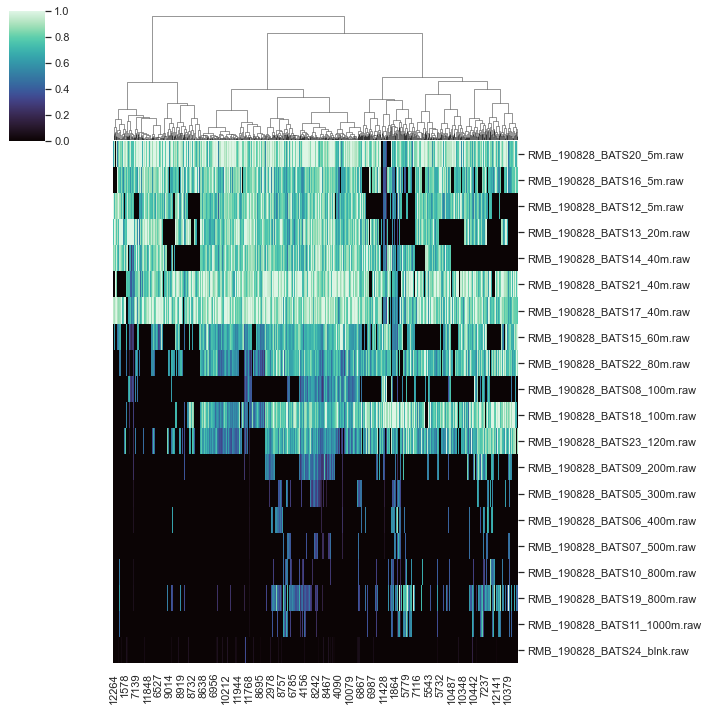

In [50]:
#Define LDOM
abundances=results_clustered
abundances=abundances.sort_values(by='p',ascending=False)
abundances=abundances[abundances['cluster']==2]
abundances=abundances[masterresults_df['File'].unique()].fillna(0)
clusterplot=abundances.transpose()

print(len(abundances))
for column in clusterplot:
    current=clusterplot[column]
    clusterplot[column]=(current-min(current))/(max(current)-min(current))

clusterplot['Depth']=depth
clusterplot=clusterplot.sort_values(by='Depth')
clusterplot=clusterplot.drop(['Depth'],axis=1)
p1=sns.clustermap(clusterplot,row_cluster=False,cmap='mako',method=clustermethod)

plt.show()

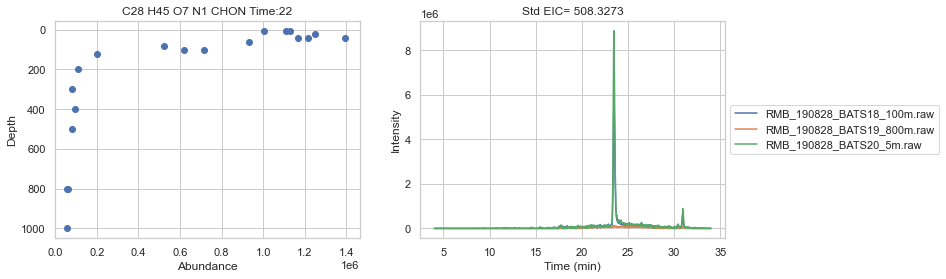

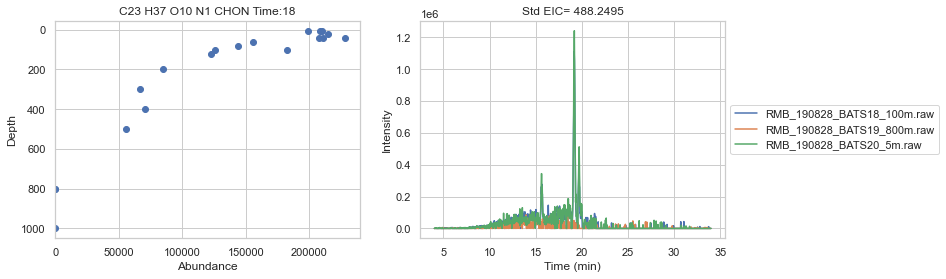

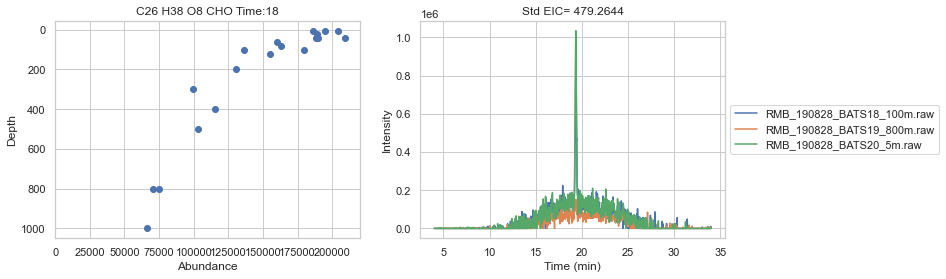

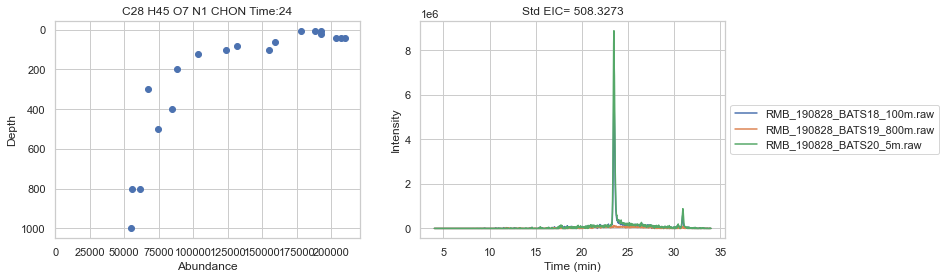

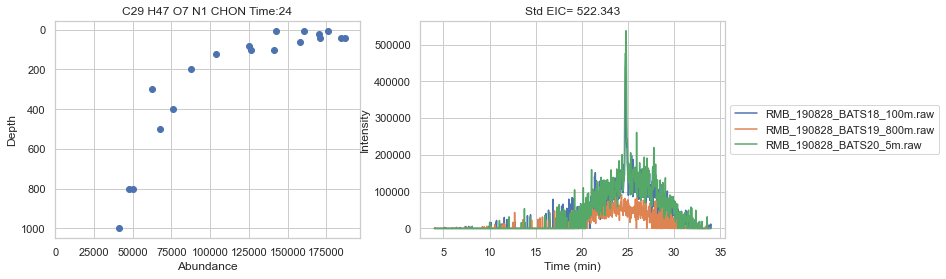

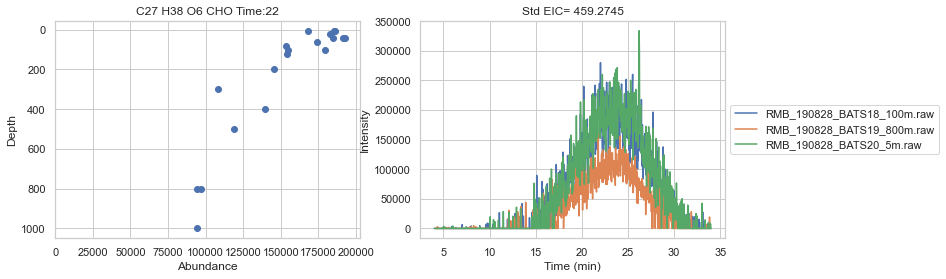

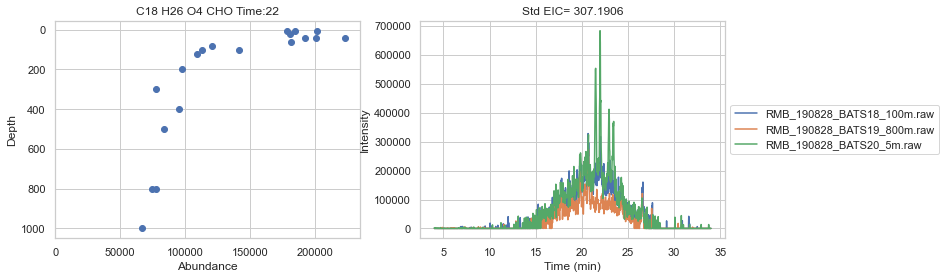

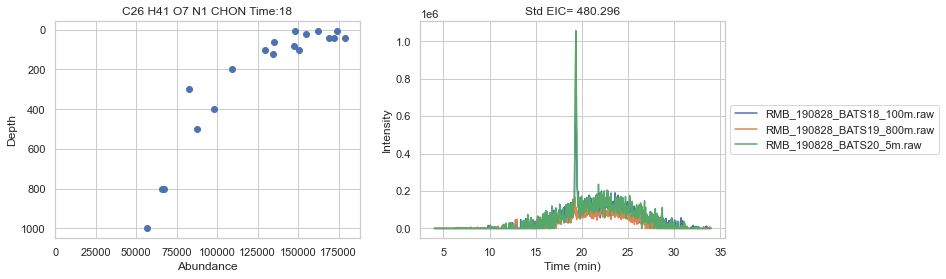

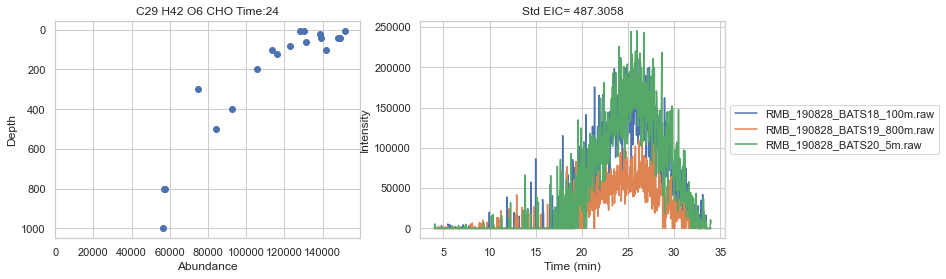

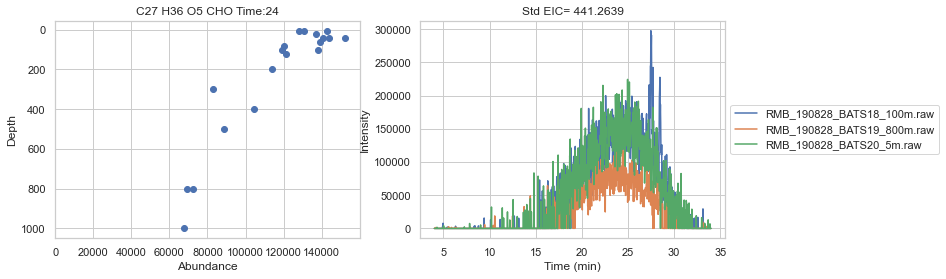

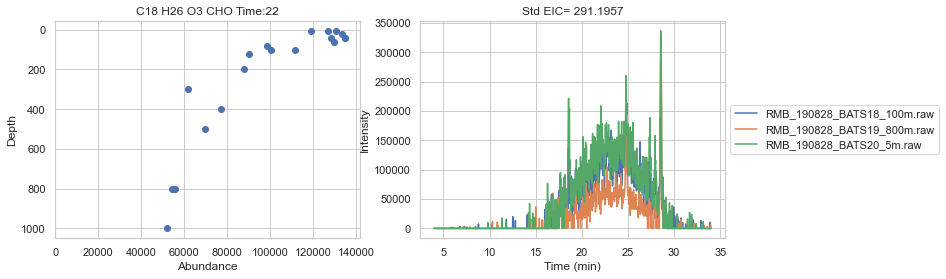

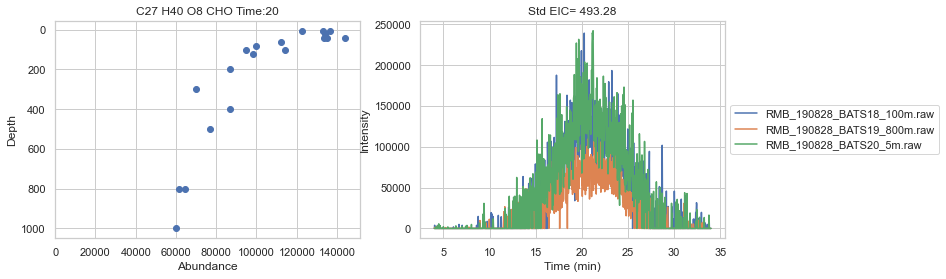

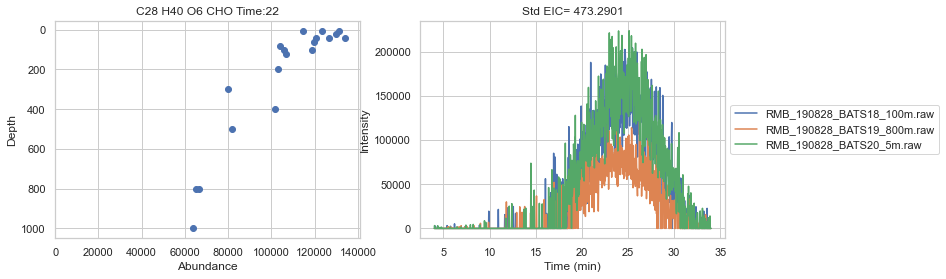

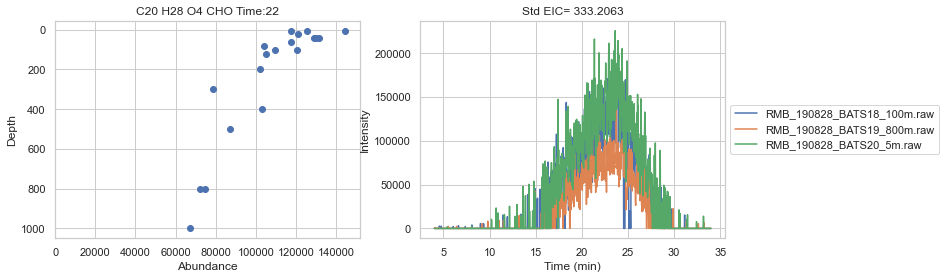

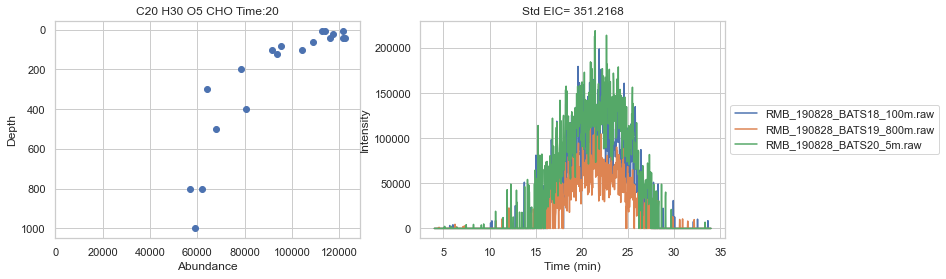

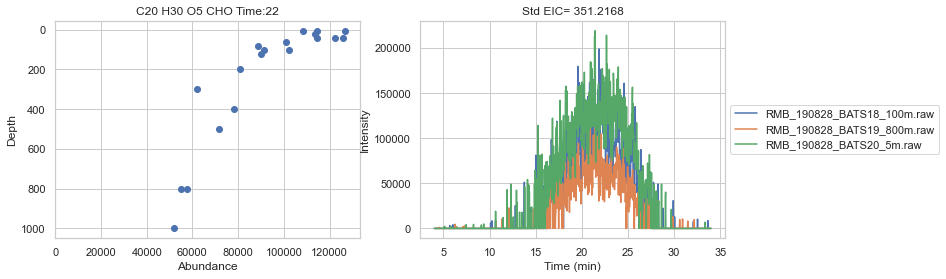

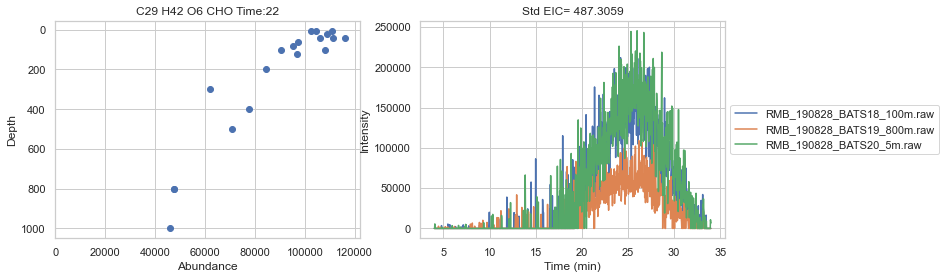

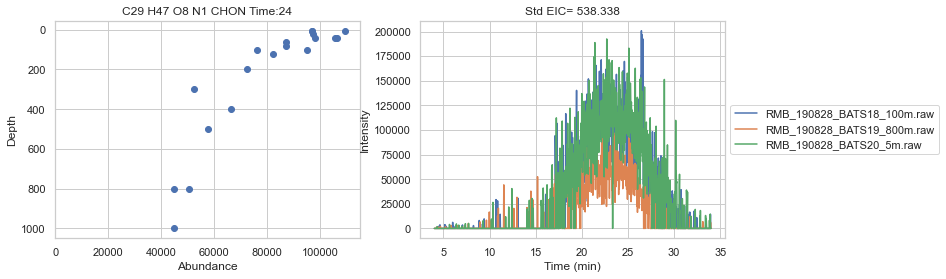

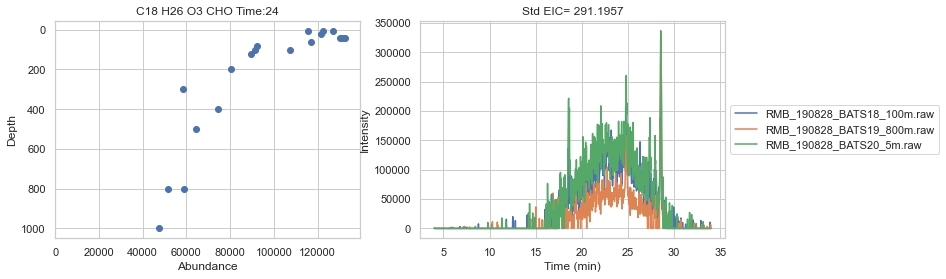

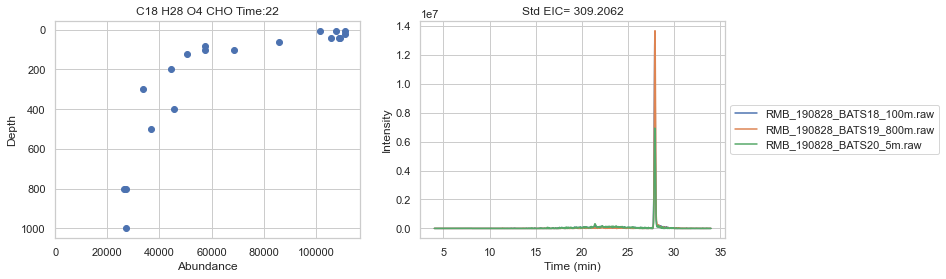

In [97]:
#Profile plotter
depth=[]
for file in masterresults_df['File'].unique():
    d=samplelist[samplelist['File']==file]['Depth'].iloc[0]
    depth.append(d)

investigate_results=results_clustered.sort_values(by='Peak Height',ascending=False)
investigate_results=investigate_results[investigate_results['cluster']==1].reset_index()

for i in range(0,20):
    result=investigate_results.loc[i]
    intensity=result[samplelist['File'].unique()].fillna(0)
    #print(result)
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(12,4)
    ax1.scatter(x=intensity,y=depth)
    ax1.set(xlabel='Abundance',xlim=[0,max(intensity)*1.05],ylabel='Depth',title=result['Molecular Formula']+' ' + result['mol_class']+ ' Time:' + str(result['Time']))
    ax1.invert_yaxis()


    stdmass=result['m/z']
    std_timerange=[4,34]

    area=[]
    rt=[]
    ax2.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass.round(4)))

    files=['RMB_190828_BATS18_100m.raw', 'RMB_190828_BATS19_800m.raw', 'RMB_190828_BATS20_5m.raw']
    #for file in MSfiles.keys():
    for file in files:

        EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
        df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
        df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
        area.append(sum(df_sub['EIC']))
        rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
        ax2.plot(df_sub['time'],df_sub['EIC'],label=file)

    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
#plt.savefig('Fig1_qcplot.eps', format='eps')


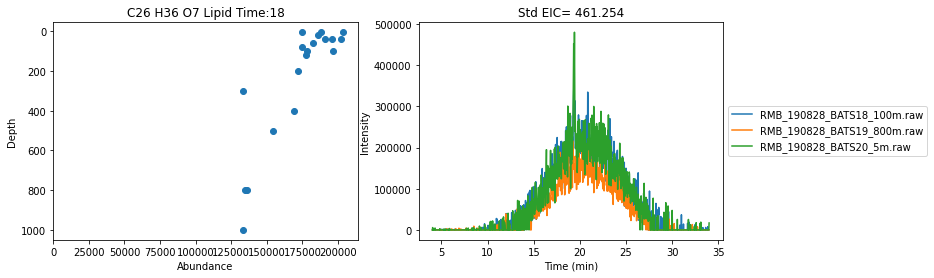

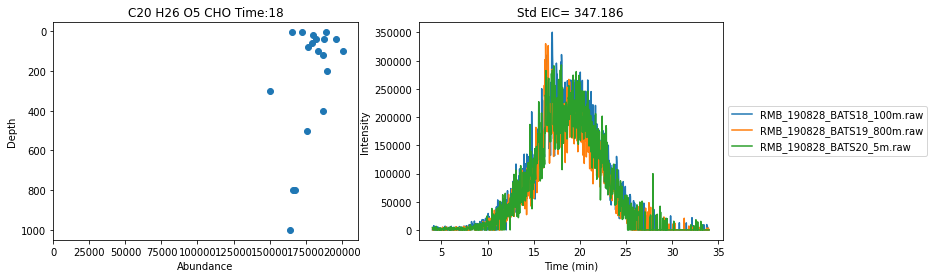

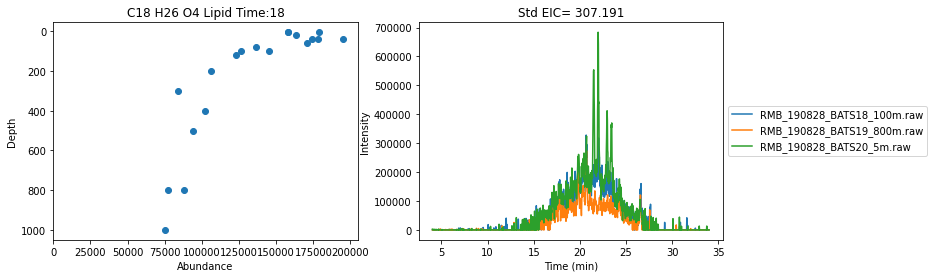

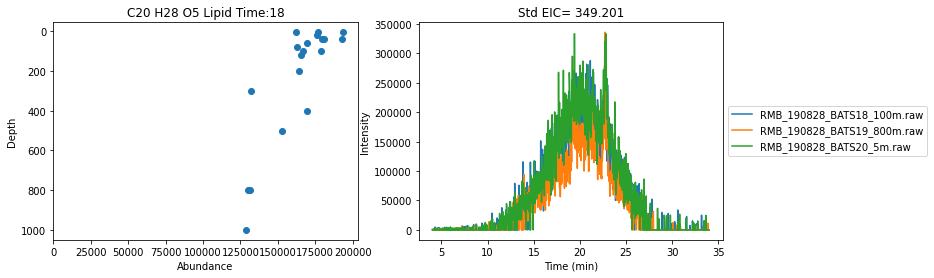

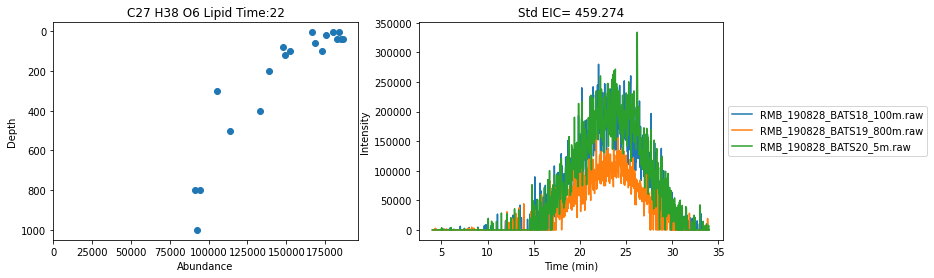

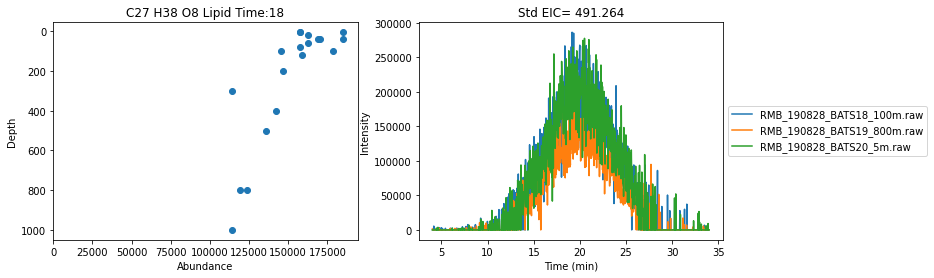

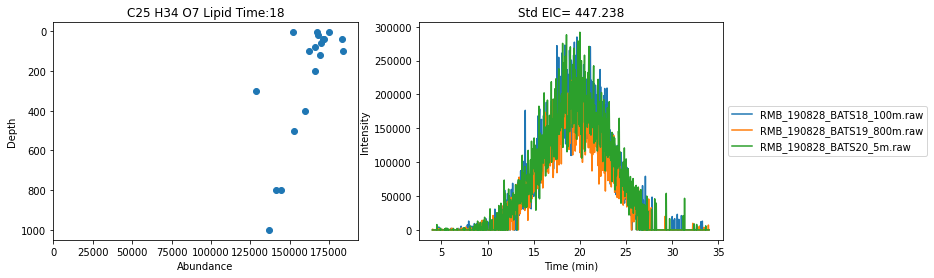

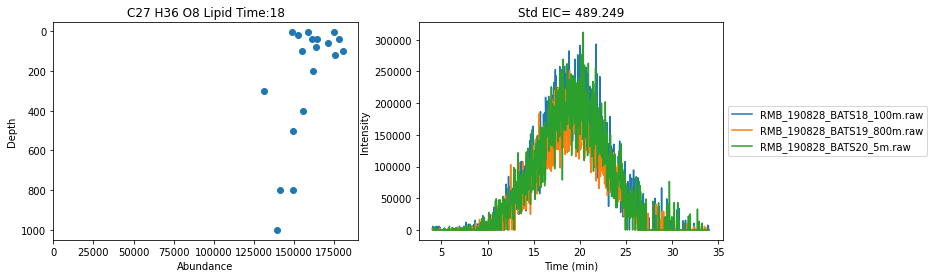

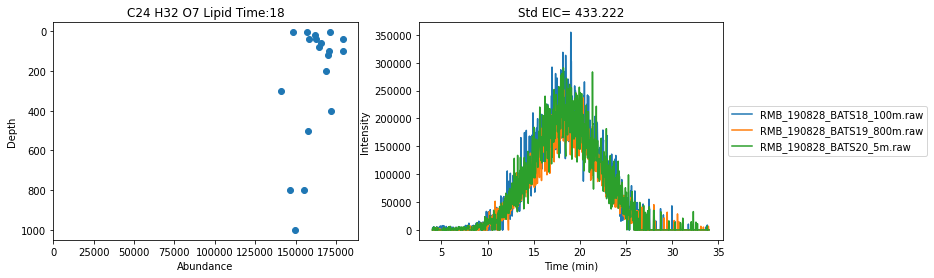

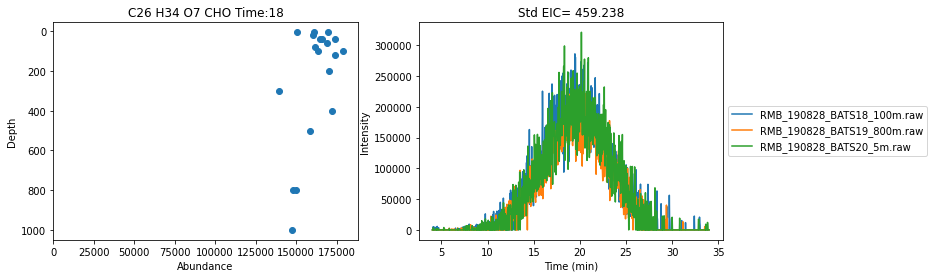

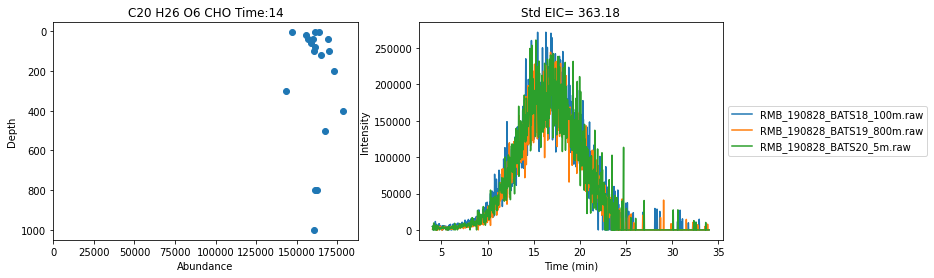

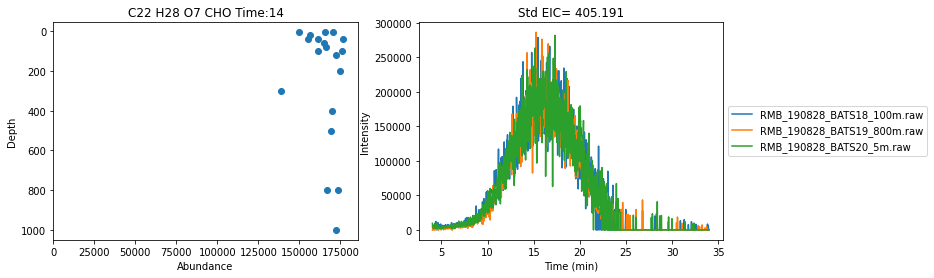

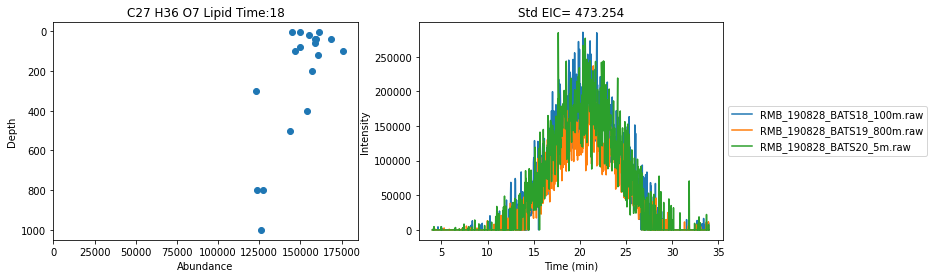

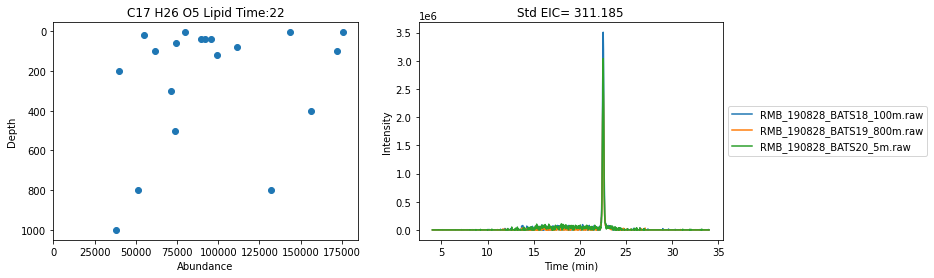

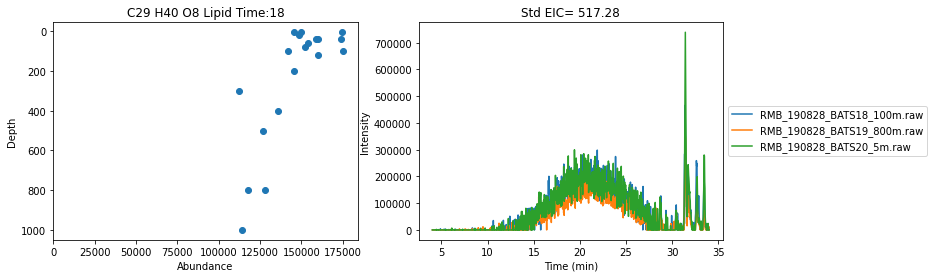

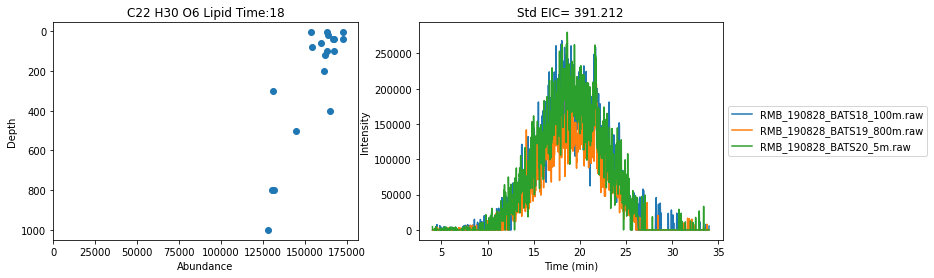

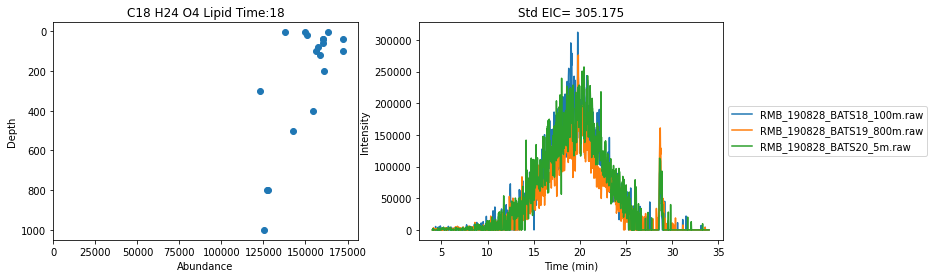

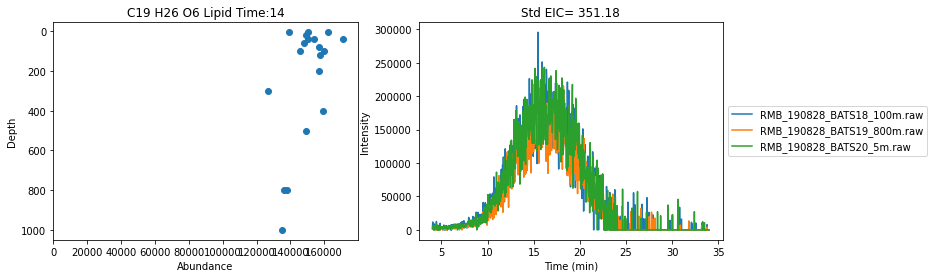

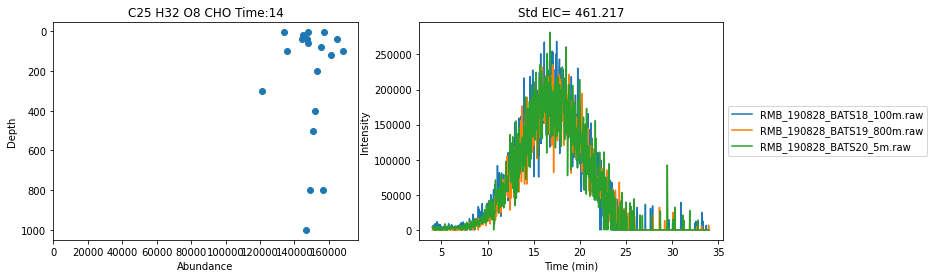

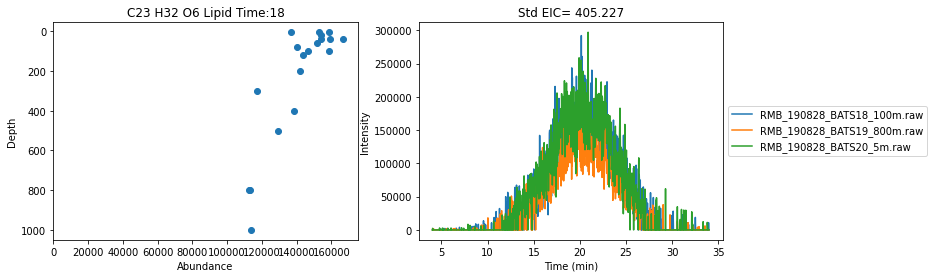

In [46]:
#Profile plotter
depth=[]
for file in masterresults_df['File'].unique():
    d=samplelist[samplelist['File']==file]['Depth'].iloc[0]
    depth.append(d)

investigate_results=results_clustered.sort_values(by='Peak Height',ascending=False)
investigate_results=investigate_results[investigate_results['cluster']==0].reset_index()

for i in range(0,20):
    result=investigate_results.loc[i]
    intensity=result[samplelist['File'].unique()].fillna(0)
    #print(result)
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(12,4)
    ax1.scatter(x=intensity,y=depth)
    ax1.set(xlabel='Abundance',xlim=[0,max(intensity)*1.05],ylabel='Depth',title=result['Molecular Formula']+' ' + result['mol_class']+ ' Time:' + str(result['Time']))
    ax1.invert_yaxis()


    stdmass=result['m/z']
    std_timerange=[4,34]

    area=[]
    rt=[]
    ax2.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass.round(3)))

    files=['RMB_190828_BATS18_100m.raw', 'RMB_190828_BATS19_800m.raw', 'RMB_190828_BATS20_5m.raw']
    #for file in MSfiles.keys():
    for file in files:

        EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
        df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
        df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
        area.append(sum(df_sub['EIC']))
        rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
        ax2.plot(df_sub['time'],df_sub['EIC'],label=file)

    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
#plt.savefig('Fig1_qcplot.eps', format='eps')


In [ ]:

stdmass=678.2918
std_timerange=[13.2,14]

#QC control 

#stdmass=389.1960
#std_timerange=[5,30]

area=[]
rt=[]
fig=plt.figure()
ax=plt.subplot(111)
ax.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass))

for file in MSfiles.keys():
    EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
    df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
    df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
    area.append(sum(df_sub['EIC']))
    rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
    ax.plot(df_sub['time'],df_sub['EIC'],label=file)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

samplelist['qc_area']=area
samplelist['qc_rt']=rt

#plt.savefig('Fig1_qcplot.eps', format='eps')

plt.show()


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

#linked = linkage(X, 'single')

#labelList = range(1, 11)

#plt.figure(figsize=(10, 7))
#dendrogram(linked,
#            orientation='top',
#            labels=labelList,
#            distance_sort='descending',
#            show_leaf_counts=True)
#plt.show()